## This script is used to generate plots related.

In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# define the repository path
from common_settings import  obspath, outpath, events_name, \
    obs_events, day_load_flow, hour_load_flow, conct_name, modpath, mod_load_flow

from utils.plotting import cq_line_plot
from utils.concentration import cumulative_lq, excel_save
from utils.signatures import update_cumul_df, load_flow_loc

### The double-mass plot of flow and loads

In [2]:
def double_mass_line(df, xycols, fs, xlabel, ylabel, color=None, legd=None, ls=None, ax=None):
    ax = df.plot(x=xycols[0], y= xycols[1], ax=ax, ls=ls, color=color)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    return ax

In [3]:
fn_day = 'obs_year_cumulative_ratio_day'
df_day = pd.read_excel(f'{outpath}{fn_day}.xlsx', sheet_name=[f'obs_year_{i}' for i in range(9)]);

In [4]:
fn_hour = 'obs_year_cumulative_ratio_hour'
df_hour = pd.read_excel(f'{outpath}{fn_hour}.xlsx', None);

In [5]:
fn_mod = 'mod_year_cumulative_ratio_day'
df_mod = pd.read_excel(f'{outpath}{fn_mod}.xlsx', None);

In [9]:
# read inputs (*cumulative_ratio*.xlsx)
xylabel = ['cumul_flow_ratio', 'cumul_load_ratio']
xlabel='Normalized cumulative flow volume'
ylabel='Normalized cumulative mass'
fs=20; fs_legd = 16

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


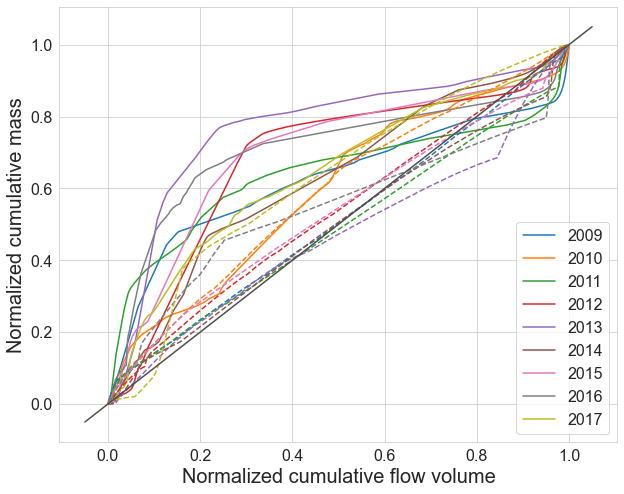

In [11]:
sns.set_style('whitegrid')
sns.color_palette("tab10")
# sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
legd = []
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
ii = 0
for _, val in df_day.items():
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax)
    ii += 1
# for _, val in df_hour.items():
#     legd.append(str(val.values[0][0])[0:4])
#     double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax, ls='-.')
ii = 0
for _, val in df_mod.items():    
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax, ls='--')
    ii += 1
ax.legend(legd[0:9], fontsize=fs_legd);
ax.plot(ax.get_xlim(), ax.get_xlim(), c=".3")
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size = 16);
ax.set_xticklabels(np.round(ax.get_xticks(), 2), size = 16);
plt.savefig(f'{outpath}figs/{fn_day}.png', format='png', dpi=400)

### Plot Event Mean Concentration (EMC)

In [36]:
# import EMC and tranform into a matrix
emc = pd.read_csv(f'{outpath}obs_storm_event_common2.csv', index_col='ID')
emc_mod = pd.read_csv(f'{outpath}DIN_mod_storm_event_common2.csv', index_col='ID')

In [37]:
emc_matrix = {year: [] for year in range(2009, 2018)}
emc_mod_matrix = {year: [] for year in range(2009, 2018)}
# emc_matrix = {year: [] for year in range(2009, 2014)}
emc.start = pd.to_datetime(emc.start)
emc_mod.start = pd.to_datetime(emc_mod.start)

In [4]:
col_plt = ['event_load_coefficients', 'emc(mg/l)'][1]
fig_names = ['event_load_coefficients', 'emc'][1]
for ii in emc.index:
    if emc.start[ii].month < 7:
        emc_matrix[emc.start[ii].year - 1].append(emc.loc[ii, col_plt]) #event_load_coefficients
    else:
        emc_matrix[emc.start[ii].year].append(emc.loc[ii, col_plt])
# convert dict into a dataframe
df_fillna = pd.DataFrame(index=np.arange(1, 15), columns=emc_matrix.keys())
mod_df_fillna = pd.DataFrame(index=np.arange(1, 15), columns=emc_matrix.keys())
for key, val in emc_matrix.items():
    df_fillna.loc[0:len(val), key] = val
    
df_fillna.fillna(0, inplace=True)
# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True

# For mod    
for ii in emc_mod.index:
    if emc_mod.start[ii].month < 7:
        emc_mod_matrix[emc_mod.start[ii].year - 1].append(emc_mod.loc[ii, col_plt])
    else:
        emc_mod_matrix[emc_mod.start[ii].year].append(emc_mod.loc[ii, col_plt])
        
for key, val in emc_mod_matrix.items():
    mod_df_fillna.loc[0:len(val), key] = val

mod_df_fillna.fillna(0, inplace=True)
# creat a mask
mod_mask = np.zeros_like(mod_df_fillna.values)
mod_mask[mod_df_fillna == 0] = True

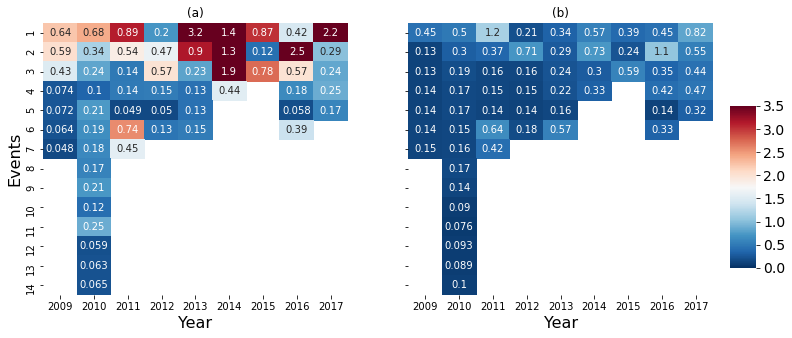

In [10]:
# sns.set_context({"figure.figsize":(17,5)})
sns.axes_style("white")
fig,axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
cbar_ax = fig.add_axes([.92, .2, .03, .45])
ax = sns.heatmap(data=np.array(df_fillna.values), annot=True, mask=mask, vmin=0, vmax=1,
            xticklabels=df_fillna.columns, yticklabels= df_fillna.index,cmap="RdBu_r", ax=axes[0], cbar=0)
ax1 = sns.heatmap(data=np.array(mod_df_fillna.values), annot=True, mask=mod_mask, vmin=0, vmax=3.5,
            xticklabels=mod_df_fillna.columns, yticklabels= mod_df_fillna.index,cmap="RdBu_r", ax=axes[1], cbar_ax=cbar_ax)
ax.set_title('(a)')
ax1.set_title('(b)')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Events', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14);
plt.savefig(f'{outpath}figs/obs_mod_{fig_names}_common2.png', format='png', dpi=400)

### Calculate the correlation coefficient between observed and modeled data.

In [46]:
from scipy.stats import pearsonr
prs = pearsonr(emc['event_load_coefficients'], emc_mod['event_load_coefficients'])
prs

(0.5101936956159734, 4.291010627959809e-05)

## The seasonal correlation between concentration and discharge

In [2]:
time_ranges = [[f'{year}/7/1', f'{year}/10/1', f'{year+1}/1/1', f'{year+1}/4/1', f'{year+1}/7/1'] for year in range(2009, 2018)]
df_ratio = pd.DataFrame(index=[str(year) for year in range(2009, 2018)], columns = [1, 2, 3, 4])
cols = mod_load_flow.columns # mod_load_flow, day_load_flow
conc_flow_df = mod_load_flow

In [15]:
# Calculate the correlation coefficient for each season
from scipy.stats import kendalltau
from scipy.stats import kendalltau, pearsonr
kr_all = {}
for ii in range(4):
    x, y = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], day_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        if x.shape[0] == 0:
            y = df[cols[1]].values
            x = df[cols[2]].values
        else:
            x = np.append(x, df[cols[2]].values)
            y = np.append(y, df[cols[1]].values)
    # Calculate the pearson correlation
    kr_temp = kendalltau(x, y)
    kr_all[ii] = kr_temp
    print("pearson 相关系数： ", kr_temp)

pearson 相关系数：  KendalltauResult(correlation=0.09705652246737749, pvalue=2.920073894799085e-05)
pearson 相关系数：  KendalltauResult(correlation=0.28012248080089364, pvalue=1.6754373763576252e-33)
pearson 相关系数：  KendalltauResult(correlation=-0.40385348384805203, pvalue=1.7342991921328826e-66)
pearson 相关系数：  KendalltauResult(correlation=-0.16629522773354416, pvalue=1.0551734769904672e-12)


In [ ]:
df_obs.columns

Index(['Load (kg)', 'Concentration (mg/L)', 'Flow(ML)', 'Flow  (Cumecs)',
       'Load(t)'],
      dtype='object')

In [17]:
# Form the data into four seasons
data_x, data_y = {'mod':{}, 'obs':{}}, {'mod':{}, 'obs':{}}
x_col, y_col = cols[2], cols[0]
for ii in range(4):
    x, y = np.array([]), np.array([])
    x_obs, y_obs = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], mod_load_flow, timestep ='d')
        df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')

        if x.shape[0] == 0:
            x = df[x_col].values
            y = df[y_col].values
            x_obs = df_obs[x_col].values
            y_obs = df_obs[y_col].values
        else:
            x = np.append(x, df[x_col].values)
            y = np.append(y, df[y_col].values)
            x_obs = np.append(x_obs, df_obs[x_col].values)
            y_obs = np.append(y_obs, df_obs[y_col].values)

    data_x['mod'][f'x_{ii}'] = x
    data_y['mod'][f'y_{ii}'] = y
    data_x['obs'][f'x_{ii}'] = x_obs
    data_y['obs'][f'y_{ii}'] = y_obs

In [ ]:
# Use plotly to creat scatter plots
from statistics import mode
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Initialize figure with subplots
fig = make_subplots(rows=1, cols=4, shared_yaxes=True, shared_xaxes=True)
legends = ['Jul.-Sep.', 'Oct.-Dec.', 'Jan.-Mar.', 'Apr.-Jun.']

for ii in range(4):
    fig.add_trace(
        go.Scatter(x=data_x['mod'][f'x_{ii}'], y=data_y['mod'][f'y_{ii}'], mode='markers', name=legends[ii]),
        row=1, col=ii+1     
    )

for ii in range(4):
    fig.add_trace(
        go.Scatter(x=data_x['obs'][f'x_{ii}'], y=data_y['obs'][f'y_{ii}'], mode='markers', name=''),
        row=1, col=ii+1     
    )

    fig.update_xaxes(
        showexponent = 'all',
        exponentformat = 'e',
        row=1, col=ii+1 
    )
fig.update_layout(height=400, width=1200)
fig.update_xaxes(type="log", range=[-1, 5], title_text='Flow (ML)')
fig.update_yaxes(type="log", range=[-3, 5])
fig.update_traces(marker_size=3)
fig.update_layout(
    yaxis = dict(
        showexponent = 'all',
        exponentformat = 'e',
        title_text = 'Load (kg)'
    )
)

fig.show()
# pio.write_image(fig, '../output/figs/SSL-Q_mod.png')

## Plot month summarized metrics

In [40]:
df_month = pd.read_csv(f'{outpath}mod_obs_annual.csv', index_col = 'Year')
df_month = df_month / 1000
df_month['bias'] = np.round((1- np.abs(df_month['obs'] - df_month['mod']) / df_month['obs']), 2)

In [41]:
import plotly.graph_objects as go
import plotly.offline as py
import plotly
import plotly.io as pio
#setting offilne
plotly.offline.init_notebook_mode(connected=True)
trace0 = go.Bar(
    x = df_month.index,
    y = df_month['obs'].values,
    name = 'Measurement',
    marker = dict(
        color = 'rgb(49,130,189)'
    ),
)
trace1 = go.Bar(
    x = df_month.index,
    y = df_month['mod'].values,
    name = 'Simulation',
    marker=dict(
        color = 'rgb(204,204,204)'
    )
)
data = [trace0,trace1]
fig = go.Figure(data)
fig.update_layout(autosize=False,
        width=800, height=500, margin=dict(l=20, r=20, t=20, b=20),
         xaxis=dict(title_text = 'Year', 
                    titlefont=dict(size=20, family='Arial')),
         yaxis=dict(title_text = 'Annual DIN load (t)',
                    titlefont=dict(size=20, family='Arial')),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.78, 
                    font=dict(size=20)), font_family="Arial", font_color='black')
fig.update_xaxes(tickfont=dict(family='Arial', color='black', size=20))
fig.update_yaxes(tickfont=dict(family='Arial', color='black', size=20))
x_annot = np.linspace(0, 9, 10)
y_annot = [55, 105, 60, 60, 60, 30, 45, 82, 20, 55]
for ii in range(10):
    fig.add_annotation(x = x_annot[ii], y = y_annot[ii],
                text=df_month['bias'].values[ii],
                showarrow=False,
                arrowhead=1, 
                font = dict(size=16))

# fig.show()
pio.write_image(fig, 'annual_load_bias_plotly.png')

## Plot long term C-Q relationship

In [2]:
time_ranges = ['2009/7/1', '2014/6/30'] 
cols = day_load_flow.columns
day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


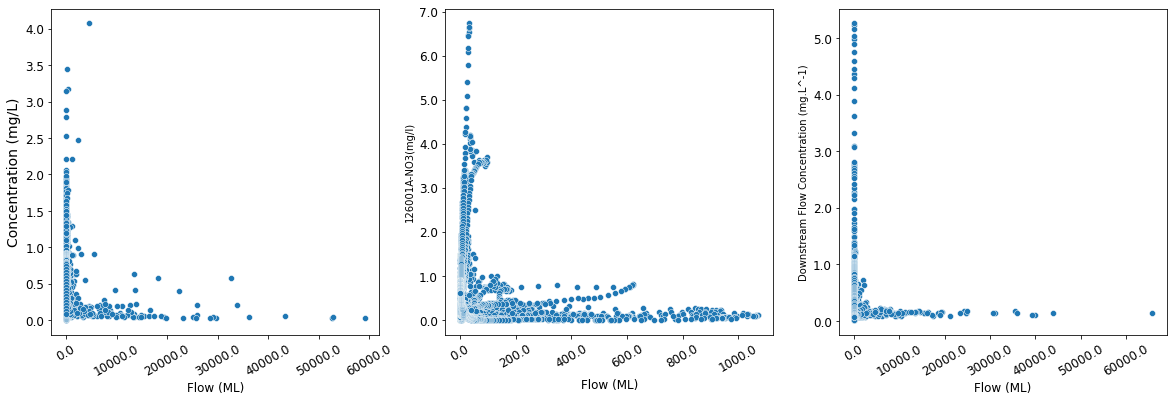

In [9]:
_, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=False)
start, end = pd.to_datetime(time_ranges)
# plot low-freq-obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
cols = day_load_flow.columns
sns.scatterplot(data=df_obs, x=cols[2], y=cols[3], ax=axes[0])

# plot high-freq-obs in axes[1]
df_obs_hour = load_flow_loc(['2018/7/1', '2020/6/30'], hour_load_flow, timestep ='h')
cols = hour_load_flow.columns
sns.scatterplot(data=df_obs_hour, x=cols[0], y=cols[1], ax=axes[1])

# plot mod in axes[1]
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
cols = mod_load_flow.columns
sns.scatterplot(data=df_mod, x=cols[2], y=cols[1], ax=axes[2])
for ax in axes:
#     ax.set(xscale="log", yscale="log")
    ax.set_xticklabels(ax.get_xticks(), fontsize=12, rotation=30)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlabel('Flow (ML)', fontsize=12)
axes[0].set_ylabel('Concentration (mg/L)', fontsize=14); #Load (kg) Concentration (mg/l)
# plt.savefig(f'{outpath}figs/obs_mod_longterm_load_flow.png', format='png', dpi=400, layout='tight')

## Plot long term C distribution

In [66]:
time_ranges = ['2009/7/1', '2018/6/30'] 
cols = day_load_flow.columns
# day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

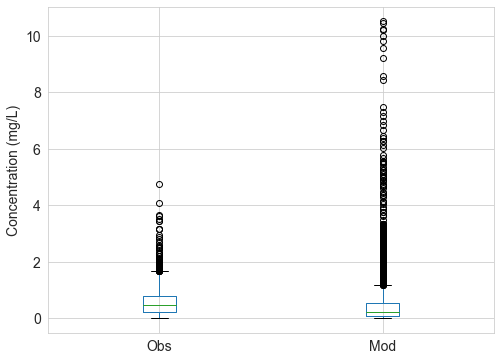

In [70]:
start, end = pd.to_datetime(time_ranges)
# plot obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
df_plot = pd.concat([df_obs.filter(regex='Con', axis=1), df_mod.filter(regex='Co', axis=1)], axis=1)
ax = df_plot.boxplot(figsize = (8, 6), fontsize=14)

ax.set_xticklabels(['Obs', 'Mod'], fontsize=14)
ax.set_ylabel('Concentration (mg/L)', fontsize=14)
plt.savefig(f'{outpath}figs/obs_mod_concentration_boxplot.png', format='png', dpi=400)